In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

# No caching and autoreload everytime we make changes to the pinn
sys.dont_write_bytecode = True
%load_ext autoreload

from model import HeatPINN

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
# Backend set up for neural networks
torch.cuda.empty_cache()
# Set seed
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)
torch.set_default_dtype(torch.float32)

# CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Heat equation

We will construct a PINN that solves an instance of a well-posed heat equation
$$
\frac{\partial u}{\partial t} = D \frac{\partial^2 u}{\partial x^2}
$$

where $D = 0.1$ on the spatial domain $x \in [-1,1]$ and time evolution $0 \leq t \leq 1$ in which solution function $u: [-1,1] \times [0,1] \to \mathbb{R}$ is imposed by
- Initial condition: $u(x,0) = \sin(\pi x)$ for all $x \in [-1,1]$
- (Left + Right) Boundary condition: $u(0,t) = u(1,t) = 0$ for all $0 \leq t \leq 1$

In [9]:
# Problem parameter
D = 0.1     # Thermal diffusivity
x_bounds = [-1, 1]
t_bounds = [0,1]

# Boundary conditions
def initial_condition(x):
    return torch.sin(np.pi * x)
    
def boundary_left(t):
    return torch.zeros_like(t)
    
def boundary_right(t):
    return torch.zeros_like(t)
    
boundary_conditions = {
    "initial_condition": initial_condition,
    "boundary_left": boundary_left,
    "boundary_right": boundary_right
}

In [10]:
# Initialize the PINN to solve this Heat equation
%autoreload 2
pinn = HeatPINN(hidden_layers=[64, 64, 64, 64, 64], activation="tanh", D=D).to(device)

In [11]:
# Training
model_path = "best_heat_pinn.pt"    # Model checkpointing path

"""
Training function 
"""
def train(pinn, x_bounds, t_bounds, boundary_conditions, model_path,
        epochs=5000, lr=0.001,
        collocation_points=2000, initial_points=2000, boundary_points=2000, 
        print_interval=100):
    
    # Setting up the optimizer
    optimizer = optim.Adam(pinn.model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min", patience=100, factor=0.5)

    # Getting the bounds
    x_min, x_max = x_bounds
    t_min, t_max = t_bounds

    # Loss history
    history = {
        "total_loss": [], 
        "residual_loss": [], 
        "initial_loss": [], 
        "boundary_loss": [],
        "mse": []
    }

    # Data of best model
    smallest_loss = float("inf")
    best_epoch = 0

    pinn.model.train()

    # Training loop
    for epoch in range(epochs):

        # Zero out the gradient in optimizer
        optimizer.zero_grad()
        
        # Sample and compute loss on collocation points  (interior domain)
        x_collocations = torch.rand(collocation_points, 1, device=device) * (x_max - x_min) + x_min
        t_collocations = torch.rand(collocation_points, 1, device=device) * (t_max - t_min) + t_min

        residual = pinn.heat_residual(x_collocations, t_collocations)
        residual_loss = torch.mean(residual**2)

        # Sampling and compute loss on initial condition points
        x_initial = torch.rand(initial_points, 1, device=device) * (x_max - x_min) + x_min
        t_initial = torch.zeros(initial_points, 1, device=device)

        ic_pred = pinn(x_initial, t_initial)
        ic_true = boundary_conditions["initial_condition"](x_initial)
        ic_loss = torch.mean((ic_pred - ic_true)**2)

        # Sampling and compute loss on boundary condition points
        x_boundary_left = torch.ones(boundary_points, 1, device=device) * x_min
        x_boundary_right = torch.ones(boundary_points, 1, device=device) * x_max
        t_boundary = torch.rand(boundary_points, 1, device=device) * (t_max - t_min) + t_min

        boundary_left_pred = pinn(x_boundary_left, t_boundary)
        boundary_right_pred = pinn(x_boundary_right, t_boundary)
        boundary_left_true = boundary_conditions["boundary_left"](t_boundary)
        boundary_right_true = boundary_conditions["boundary_right"](t_boundary)
        
        boundary_loss = torch.mean((boundary_left_pred - boundary_left_true)**2) + torch.mean((boundary_right_pred - boundary_right_true)**2)


        # Total loss (weighted combination)
        total_loss = residual_loss + 10 * (ic_loss + boundary_loss)

        # Calculate MSE (sum of unweighted losses)
        mse = residual_loss + ic_loss + boundary_loss

        # Backpropagate and update
        total_loss.backward()
        optimizer.step()
        scheduler.step(total_loss)

        # Store losses
        history["total_loss"].append(total_loss.item())
        history["residual_loss"].append(residual_loss.item())
        history["initial_loss"].append(ic_loss.item())
        history["boundary_loss"].append(boundary_loss.item())
        history["mse"].append(mse.item())
        
        # Checkpoint the model states which has the lowest loss
        if total_loss < smallest_loss:
            best_epoch = epoch
            smallest_loss = total_loss
            torch.save({
                "model": pinn.model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "scheduler": scheduler.state_dict(),
                "losses": history,
                "best_epoch": best_epoch,
                "epoch": epoch,
                "D": pinn.D,
                "x_bounds": x_bounds,
                "t_bounds": t_bounds
            }, model_path)

        # Print progress
        if epoch % print_interval == 0:
            print(f"Epoch {epoch:4d}: Total Loss = {total_loss.item():.6f} | "
                  f"Residual = {residual_loss.item():.6f} | "
                  f"Initial = {ic_loss.item():.6f} | "
                  f"Boundary = {boundary_loss.item():.6f} | "
                  f"MSE = {mse.item():.6f}")
    
    # Print best model info
    print(f"\nBest model occurred at epoch {best_epoch}, with lowest loss of {smallest_loss:.6f}")
    print(f"Model saved to: {model_path}")

    # Retutn history for optional visualization
    return history

In [12]:
history = train(
    pinn=pinn,
    x_bounds=x_bounds,
    t_bounds=t_bounds,
    boundary_conditions=boundary_conditions,
    collocation_points=5000,
    boundary_points=1000,
    initial_points=1000,
    epochs=3001,
    lr=0.001,
    print_interval=500,
    model_path=model_path
)

Epoch    0: Total Loss = 13.183619 | Residual = 0.001689 | Initial = 0.925659 | Boundary = 0.392534 | MSE = 1.319882
Epoch  500: Total Loss = 0.038154 | Residual = 0.005081 | Initial = 0.001321 | Boundary = 0.001986 | MSE = 0.008388
Epoch 1000: Total Loss = 0.005285 | Residual = 0.003094 | Initial = 0.000109 | Boundary = 0.000110 | MSE = 0.003313
Epoch 1500: Total Loss = 0.003157 | Residual = 0.002367 | Initial = 0.000057 | Boundary = 0.000022 | MSE = 0.002446
Epoch 2000: Total Loss = 0.002383 | Residual = 0.001857 | Initial = 0.000037 | Boundary = 0.000016 | MSE = 0.001909
Epoch 2500: Total Loss = 0.001823 | Residual = 0.001450 | Initial = 0.000024 | Boundary = 0.000013 | MSE = 0.001487
Epoch 3000: Total Loss = 0.001784 | Residual = 0.001461 | Initial = 0.000021 | Boundary = 0.000011 | MSE = 0.001493

Best model occurred at epoch 2959, with lowest loss of 0.001575
Model saved to: best_heat_pinn.pt


This PDE is nice because either with Fourier transform or eigenvalue function, we can prove that this has the analytical solution
$$
u(x,t) = \sin(\pi x) e^{-D\pi^2 t}
$$

In general, many PDEs will not have readily available closed-form solution, so that is why solving DiffEq numerically is a whole field of study. 

In [13]:
# Analytical solution for this specific problem 

def analytical_solution(x, t, D=pinn.D):
    return torch.sin(torch.pi * x) * torch.exp(-D * torch.pi**2 * t)

So leveraging the analytical solution, we can benchmark how well is the trained model predictions compare to the actual solution

In [14]:
"""
    Loading checkpoint
"""
def load_model(model_path, device="cpu", silent=True):

    # Load the checkpoint
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model file not found: {model_path}")
    checkpoint = torch.load(model_path, map_location=device)

    # Print some checkpoint data to console if we are not silent (a.k.a debugging)
    if not silent:
        print(f"Model loaded from epoch {checkpoint["epoch"]}")
        print(f"Best epoch: {checkpoint["best_epoch"]}")
        print(f"Lowest loss: {checkpoint["total_loss"]:.6f}")
        print(f"Thermal diffusivity D: {checkpoint.D}")
    
    return checkpoint


"""
    Benchmarking the best checkpointed model
"""
def benchmark(model_path, analytical_solution, x_bounds=x_bounds, t_bounds=t_bounds, 
              x_plot_pts=100, t_plot_pts=100):
    
    # Load the checkpointed model
    checkpoint = load_model(model_path, device=device)
    pinn.model.load_state_dict(checkpoint["model"])
    
    # Setup domain
    x_min, x_max = x_bounds
    t_min, t_max = t_bounds
    
    x = torch.linspace(x_min, x_max, x_plot_pts, device=device)
    t = torch.linspace(t_min, t_max, t_plot_pts, device=device)
    X, T = torch.meshgrid(x, t, indexing="ij")


    x_flat = X.flatten().reshape(-1, 1)
    t_flat = T.flatten().reshape(-1, 1)
    
    # Calculate prediction
    u_pred = pinn.predict(x_flat, t_flat).cpu().numpy().reshape(x_plot_pts, t_plot_pts)
    
    # Calculate analytical solution
    u_analytical = analytical_solution(x_flat, t_flat, D=pinn.D).cpu().numpy().reshape(x_plot_pts, t_plot_pts)
    
    # Calculate error
    error = np.abs(u_pred - u_analytical)


    # Plotting
    X_np = X.cpu().numpy()
    T_np = T.cpu().numpy()
    
    fig = plt.figure(figsize=(18, 12))
    
    #  PINN Prediction
    ax1 = fig.add_subplot(2, 3, 1, projection="3d")
    surf1 = ax1.plot_surface(X_np, T_np, u_pred, cmap="viridis", alpha=0.9)
    ax1.set_xlabel("x")
    ax1.set_ylabel("t")
    ax1.set_zlabel("u(x,t)")
    ax1.set_title("PINN Prediction")
    fig.colorbar(surf1, ax=ax1)
    
    # Analytical Solution
    ax2 = fig.add_subplot(2, 3, 2, projection="3d")
    surf2 = ax2.plot_surface(X_np, T_np, u_analytical, cmap="viridis", alpha=0.9)
    ax2.set_xlabel("x")
    ax2.set_ylabel("t")
    ax2.set_zlabel("u(x,t)")
    ax2.set_title("Analytical Solution")
    fig.colorbar(surf2, ax=ax2)
    
    # Timeslices 
    ax3 = fig.add_subplot(2, 3, 3)
    time_indices = [0, t_plot_pts//4, t_plot_pts//2, 3*t_plot_pts//4, -1]
    colors = ["red", "blue", "green", "orange", "purple"]
    times = t.cpu().numpy()

    for i, idx in enumerate(time_indices):
        t_val = times[idx]
        ax3.plot(X_np[:, idx], u_pred[:, idx], 
                color=colors[i], linestyle="-", linewidth=2, label=f"PINN t={t_val:.2f}")
        ax3.plot(X_np[:, idx], u_analytical[:, idx], 
                color=colors[i], linestyle="--", alpha=0.7, label=f"Analytical t={t_val:.2f}")

    ax3.set_xlabel("x")
    ax3.set_ylabel("u(x,t)")
    ax3.set_title("Time Slices Comparison")
    ax3.legend()
    ax3.grid(True)
    
    # Heatmap PINN
    ax4 = fig.add_subplot(2, 3, 4)
    im1 = ax4.contourf(T_np, X_np, u_pred, levels=50, cmap="viridis")
    ax4.set_xlabel("t")
    ax4.set_ylabel("x")
    ax4.set_title("PINN Prediction (Heatmap)")
    fig.colorbar(im1, ax=ax4)
    
    # Heatmap Analytical
    ax5 = fig.add_subplot(2, 3, 5)
    im2 = ax5.contourf(T_np, X_np, u_analytical, levels=50, cmap="viridis")
    ax5.set_xlabel("t")
    ax5.set_ylabel("x")
    ax5.set_title("Analytical Solution (Heatmap)")
    fig.colorbar(im2, ax=ax5)
    
    #  Heatmap - Error
    ax6 = fig.add_subplot(2, 3, 6)
    im3 = ax6.contourf(T_np, X_np, error, levels=50, cmap="hot")
    ax6.set_xlabel("t")
    ax6.set_ylabel("x")
    ax6.set_title("Absolute Error (Heatmap)")
    fig.colorbar(im3, ax=ax6)
    
    plt.tight_layout()
    plt.savefig("heat_pinn_benchmark.png")
    plt.show()
    
    # Print error statistics
    print(f"Mean Absolute Error: {np.mean(error):.6e}")
    print(f"Max Absolute Error: {np.max(error):.6e}")
    print(f"RMSE: {np.sqrt(np.mean(error**2)):.6e}")

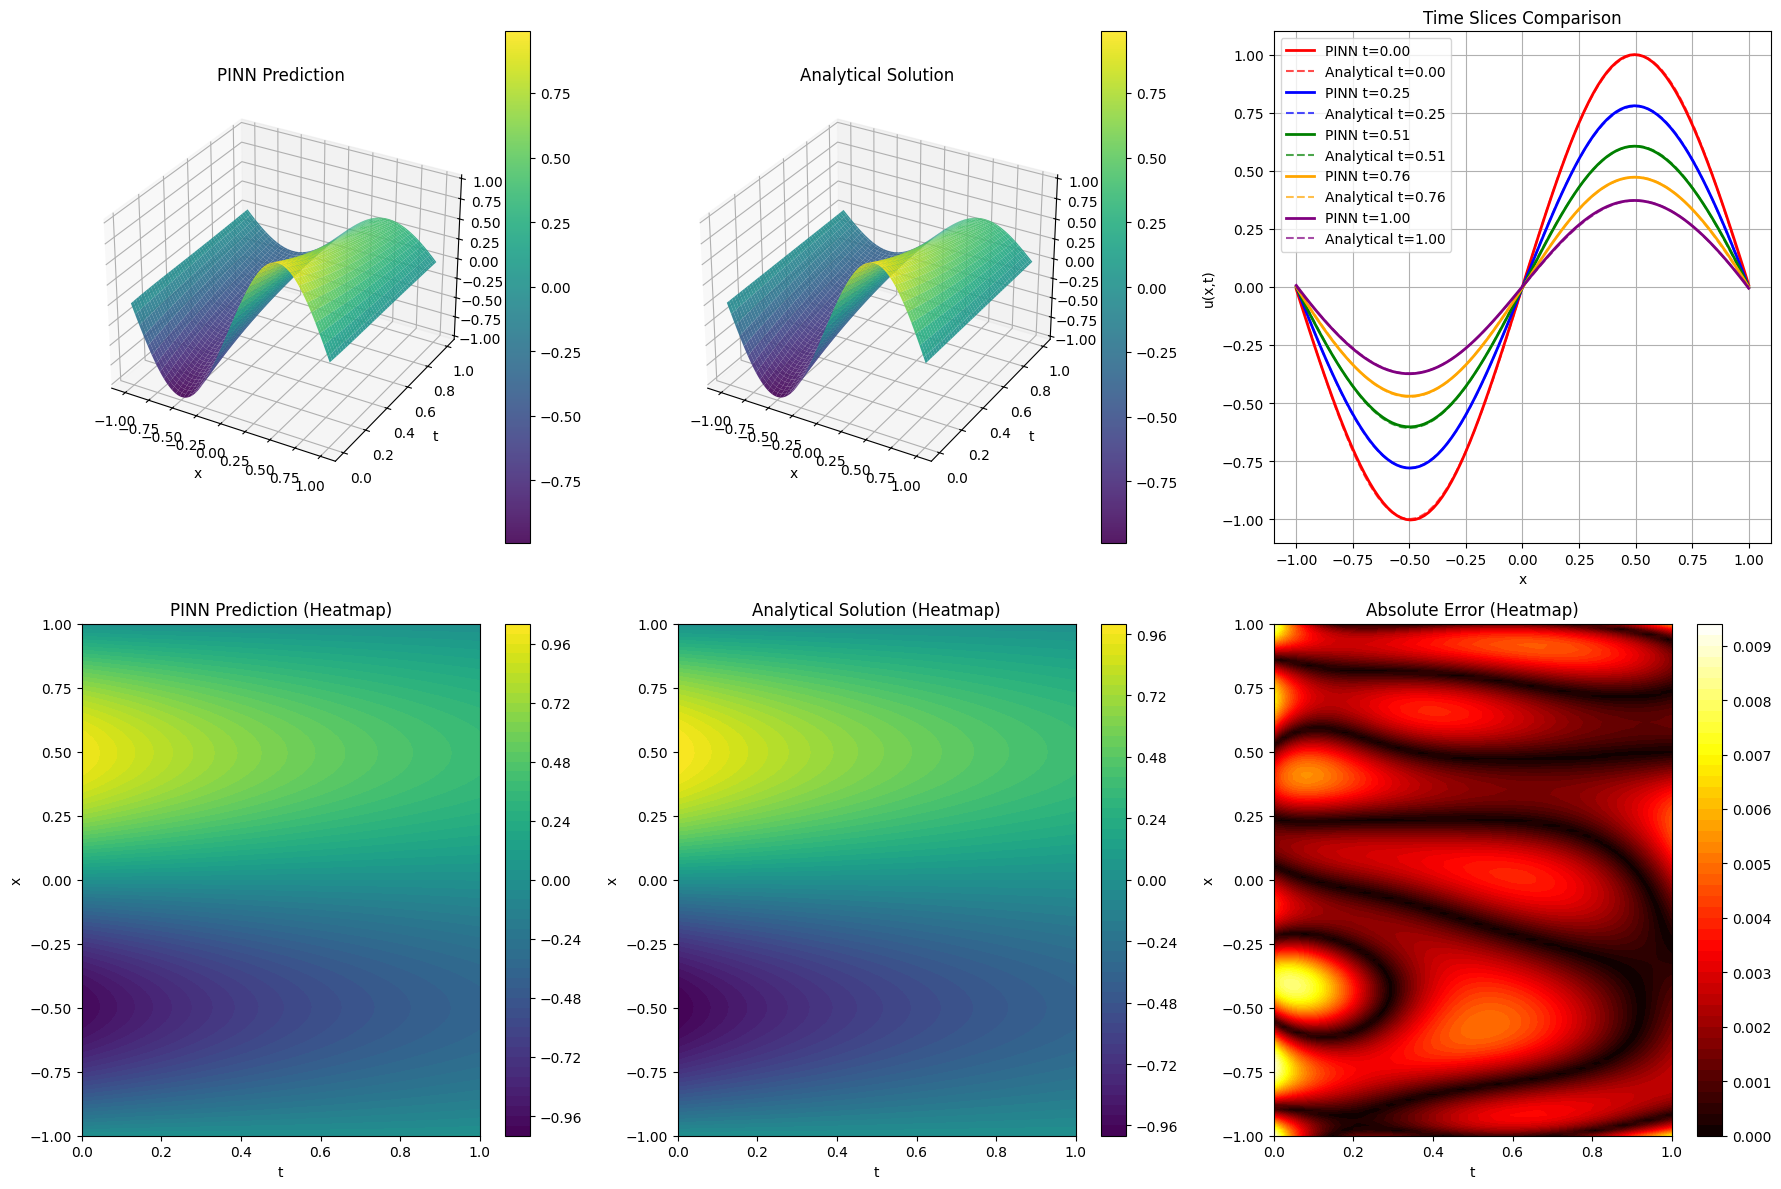

Mean Absolute Error: 2.113115e-03
Max Absolute Error: 9.217704e-03
RMSE: 2.563683e-03


In [15]:
benchmark(model_path=model_path, analytical_solution=analytical_solution)

So this performs pretty well if I do say so myself.

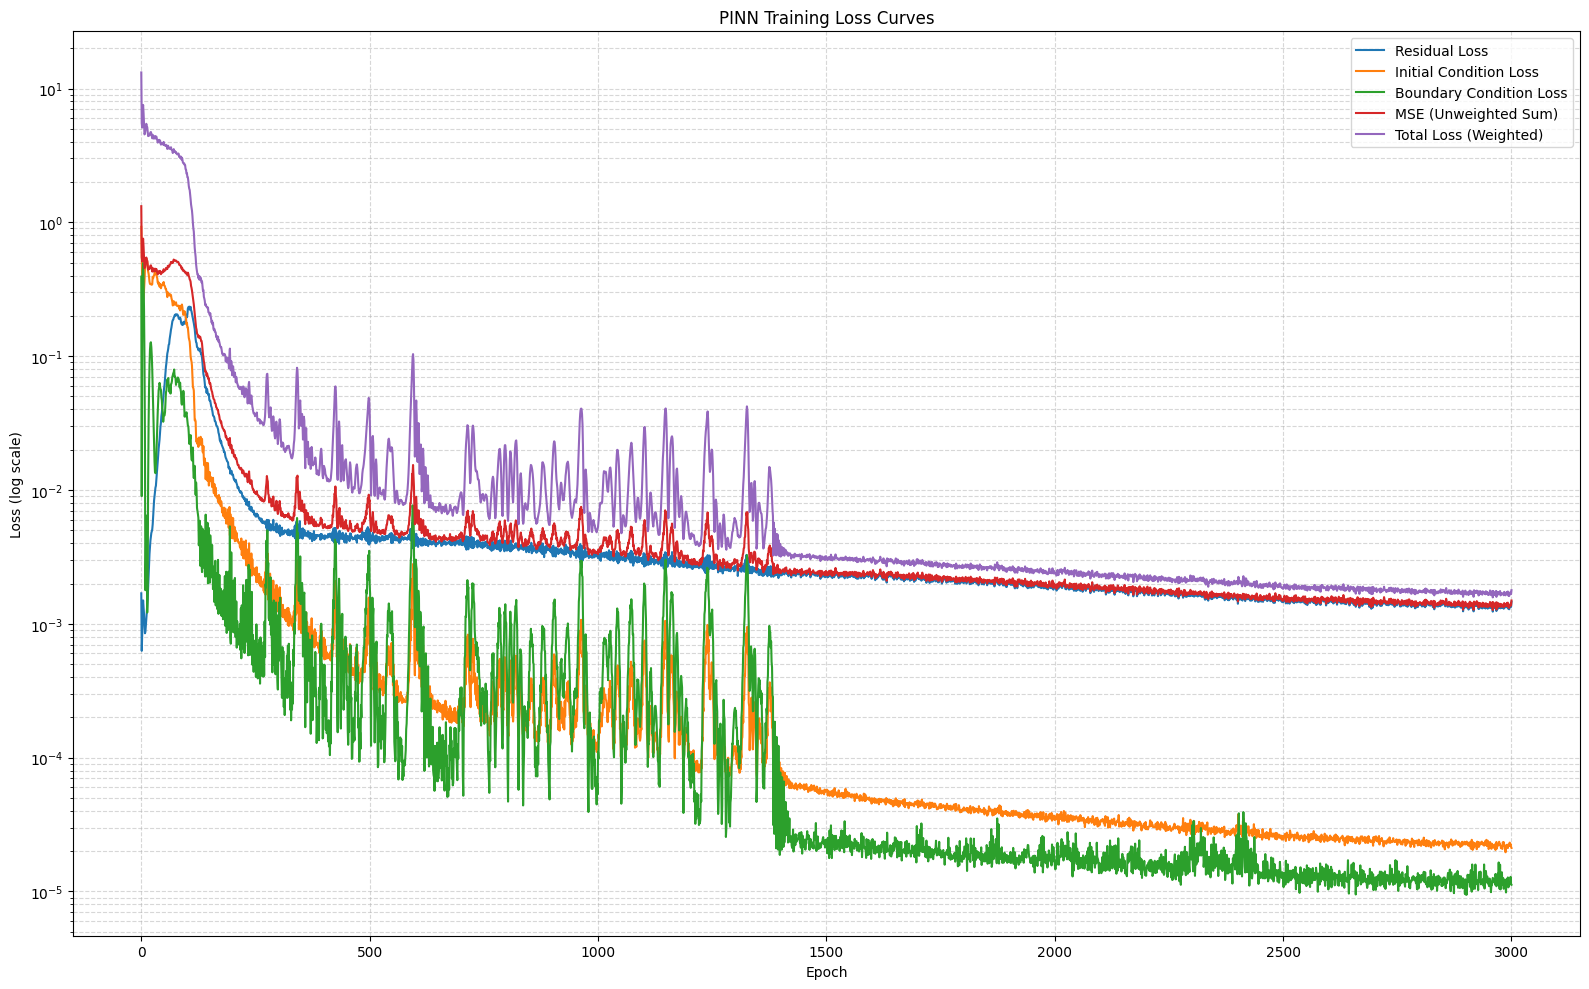

In [17]:
# OPTIONAL: Plotting losses to see how the model progresses throught the training

def plot_losses(history, save_path=None,):

    epochs = range(len(history["total_loss"]))
    
    plt.figure(figsize=(16,10))
    
    # Plot each loss component
    plt.plot(epochs, history["residual_loss"], label="Residual Loss")
    plt.plot(epochs, history["initial_loss"], label="Initial Condition Loss")
    plt.plot(epochs, history["boundary_loss"], label="Boundary Condition Loss")
    plt.plot(epochs, history["mse"], label="MSE (Unweighted Sum)")
    plt.plot(epochs, history["total_loss"], label="Total Loss (Weighted)")

    plt.yscale('log')  # Log scale for better visualization of loss dynamics
    plt.xlabel("Epoch")
    plt.ylabel("Loss (log scale)")
    plt.title("PINN Training Loss Curves")
    plt.legend()
    plt.grid(True, which="both", ls="--", alpha=0.5)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Loss plot saved to: {save_path}")
    
    plt.show()

plot_losses(history=history)